In [76]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load files

In [77]:
# atom symbol identities for test utts (410 in total)
torch_tens_path = '/Users/jonojace/GLE_samples/vqvae_group.43.upconv/gsb_0001_atom.pt'
atoms = torch.load(torch_tens_path, map_location=torch.device('cpu'))
atoms = atoms.numpy()
atoms.shape # [N, samples, n_channels, vec_len]

(30, 2701, 1)

In [78]:
# group symbol identities for test utts (41 in total)
torch_tens_path = '/Users/jonojace/GLE_samples/vqvae_group.43.upconv/gsb_0001_group.pt'
groups = torch.load(torch_tens_path, map_location=torch.device('cpu'))
groups = groups.numpy()
groups.shape # [N, samples, n_channels, vec_len]

(30, 2701, 1)

# Plot

In [79]:
plt.rcParams['figure.figsize'] = [50, 10]

In [80]:
num_to_plot = 3

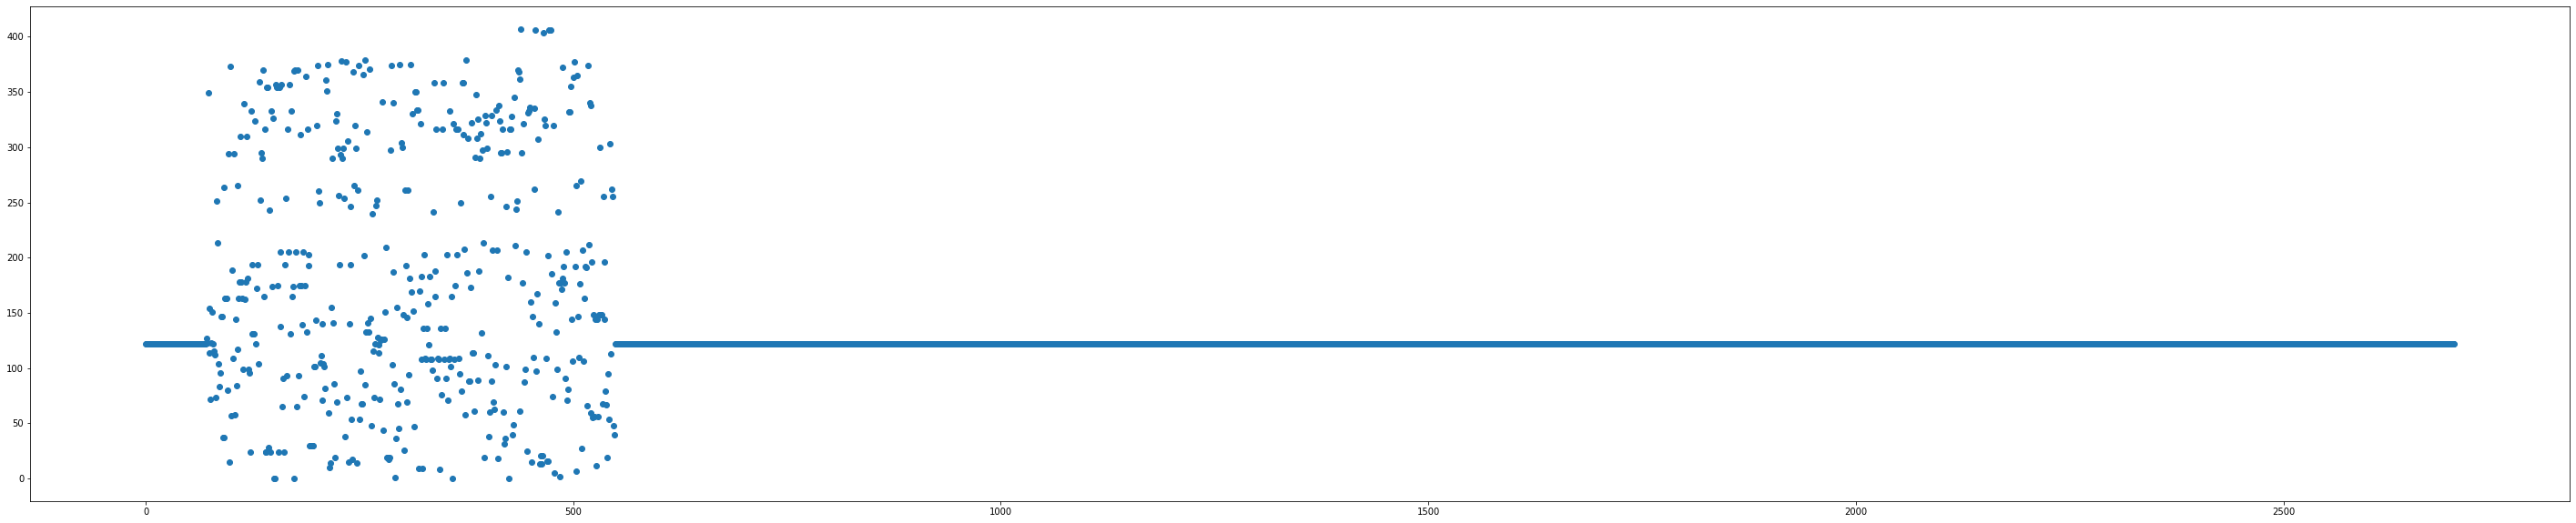

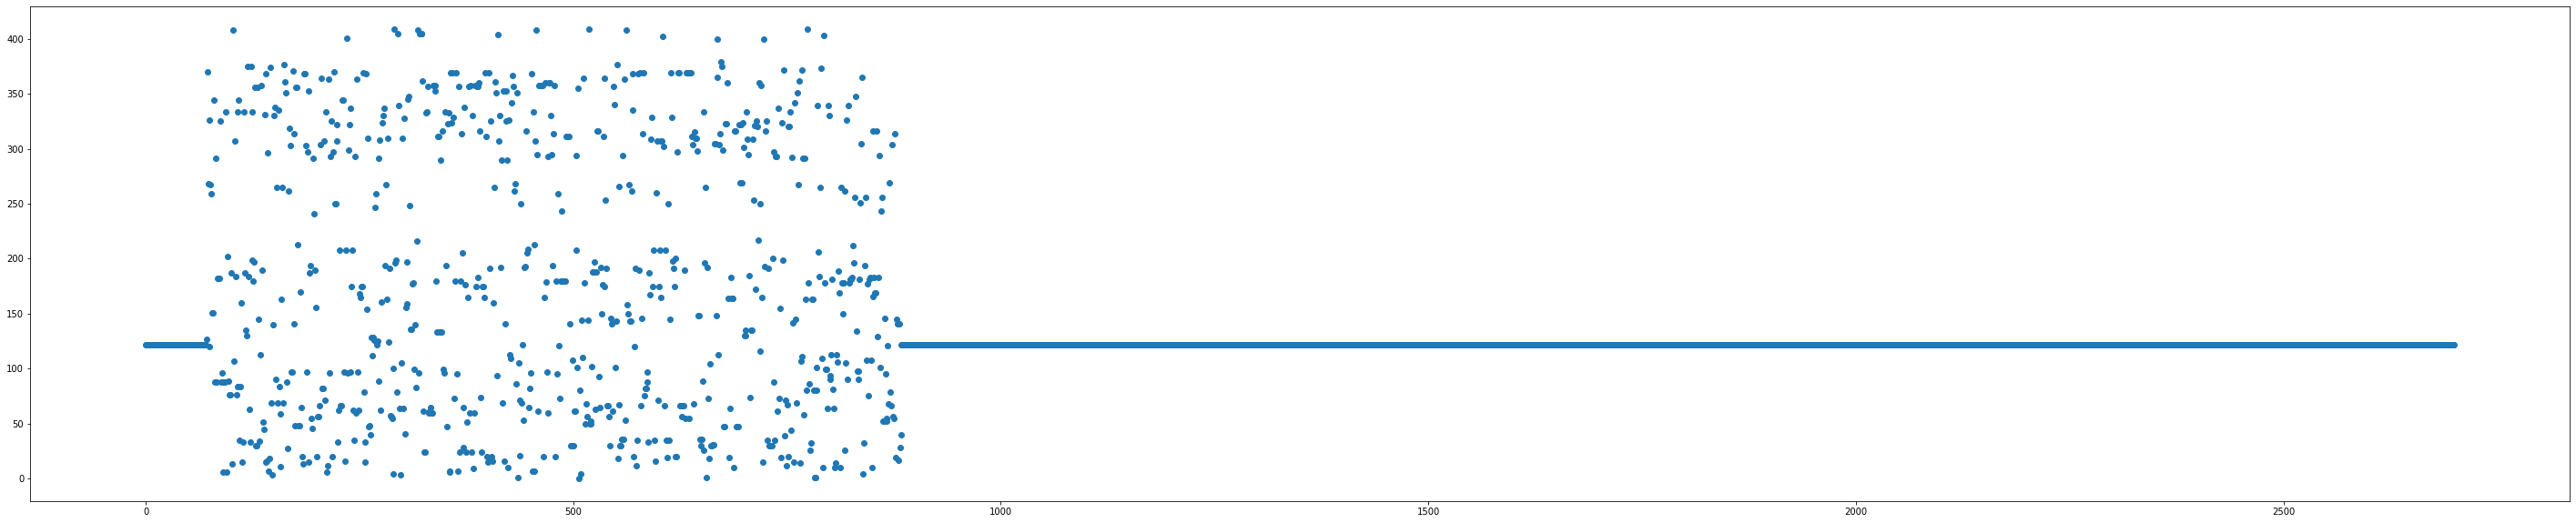

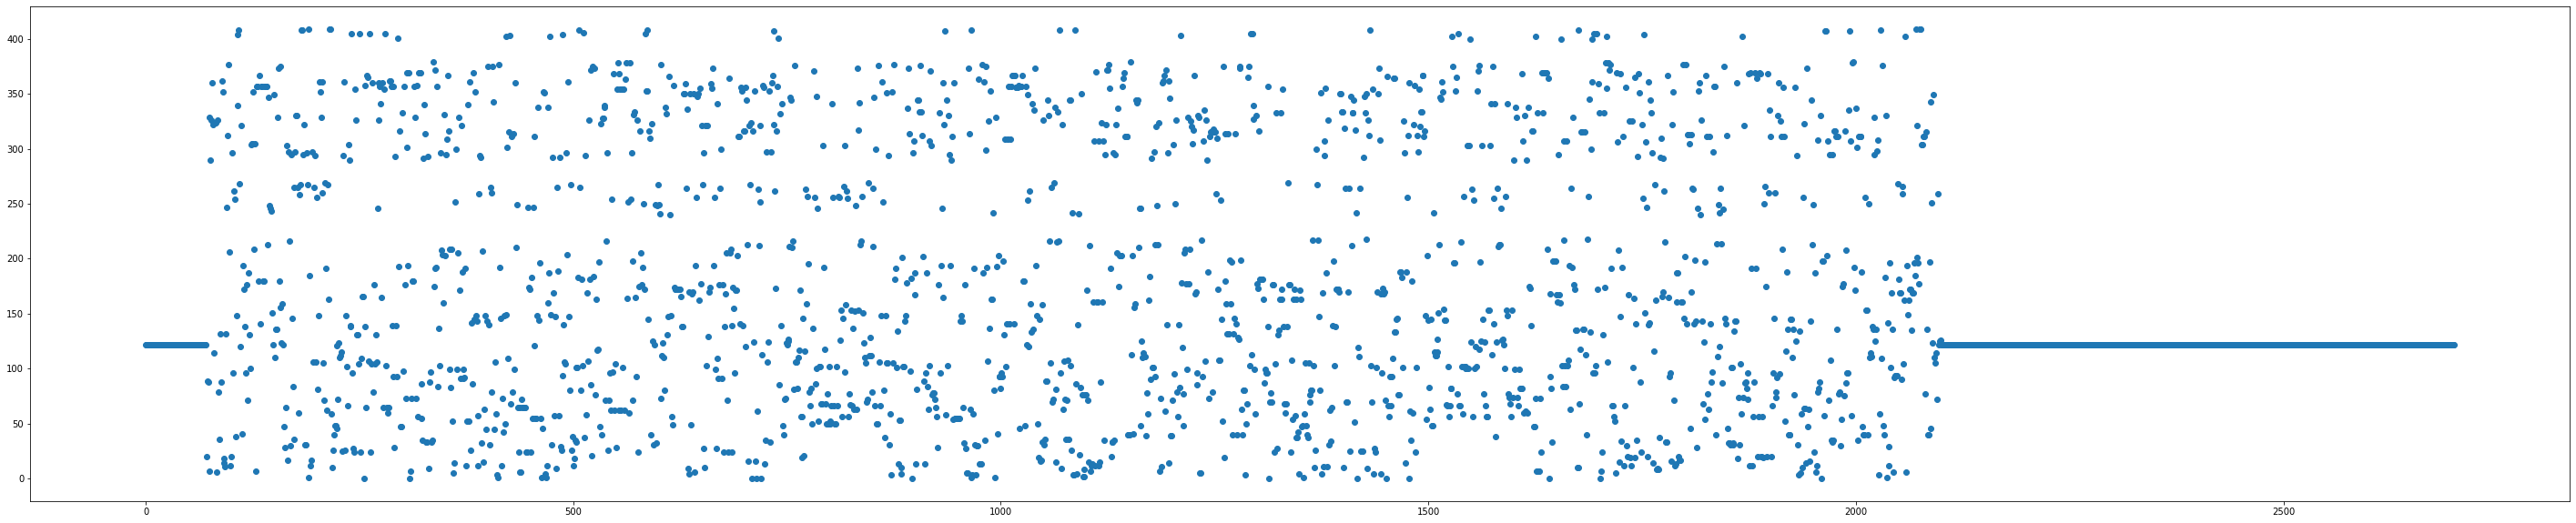

In [81]:
for y in atoms[:num_to_plot]:
    x = np.arange(len(y))
    plt.scatter(x, y)    
    plt.show()

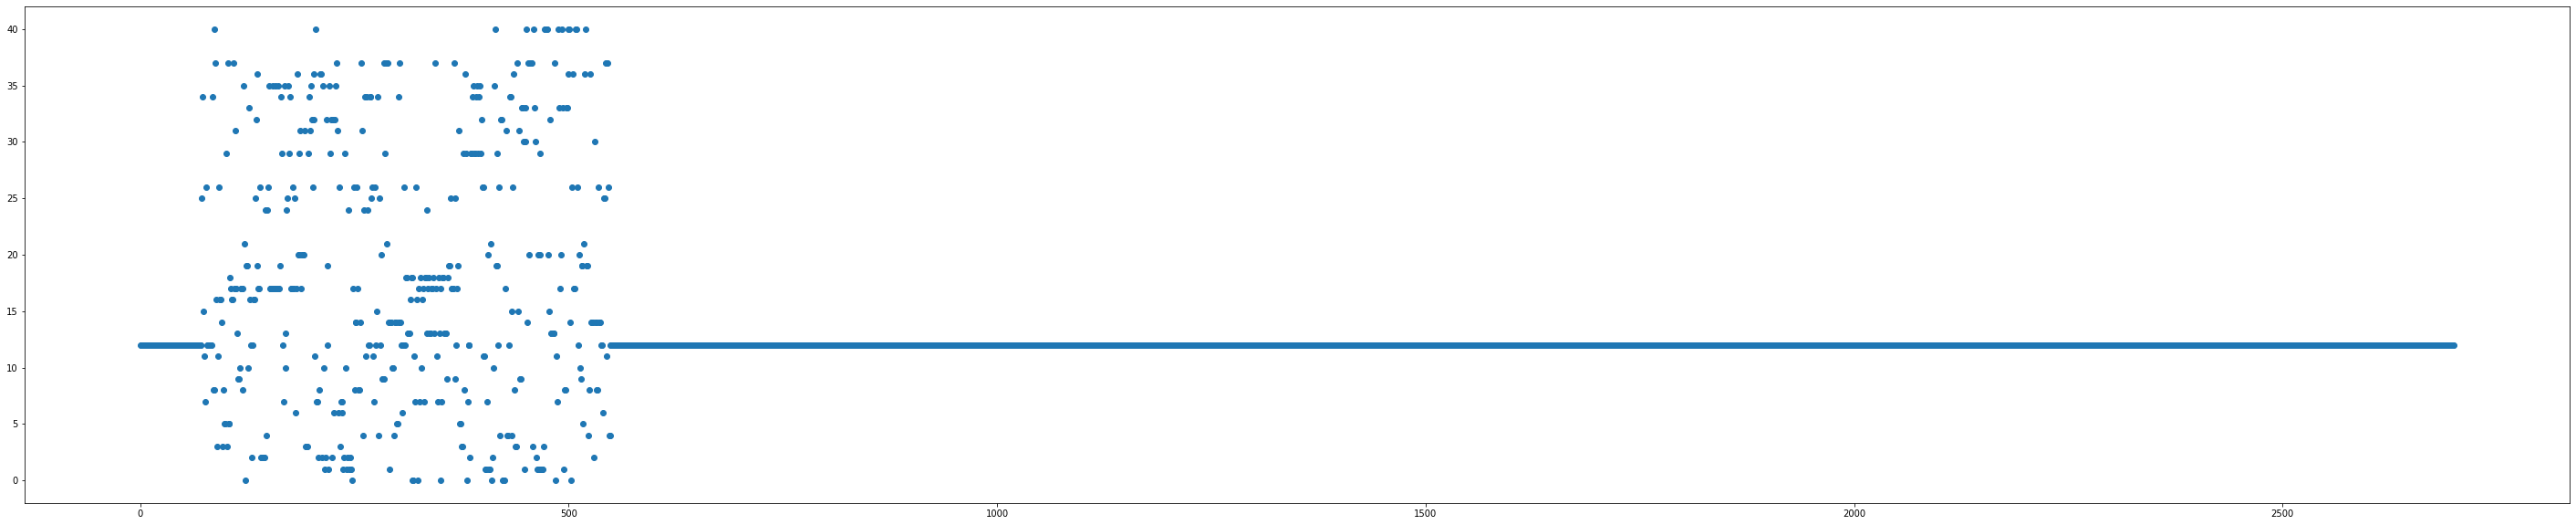

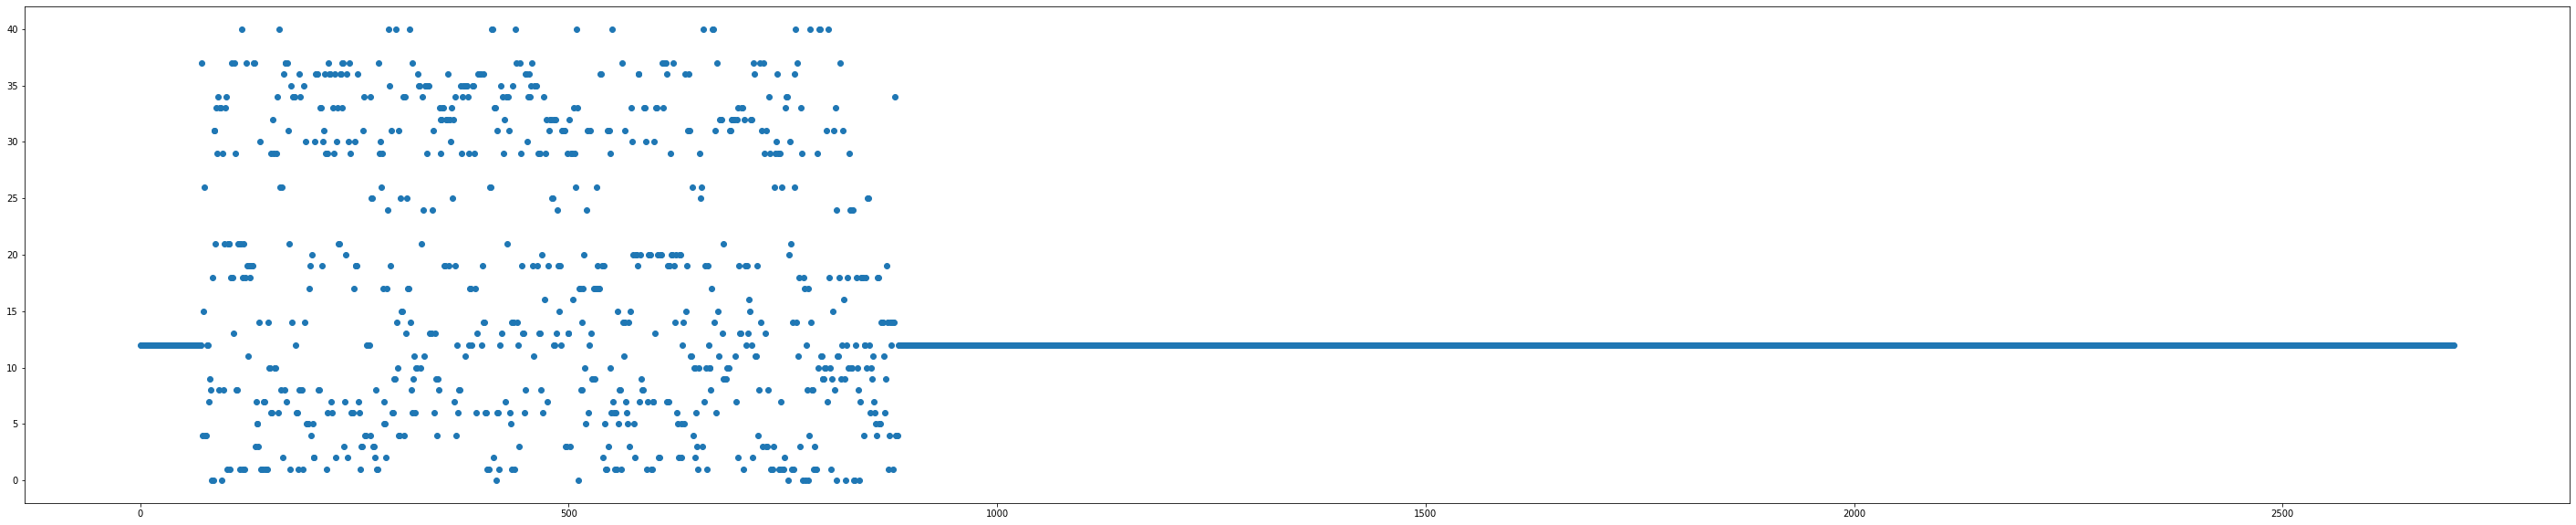

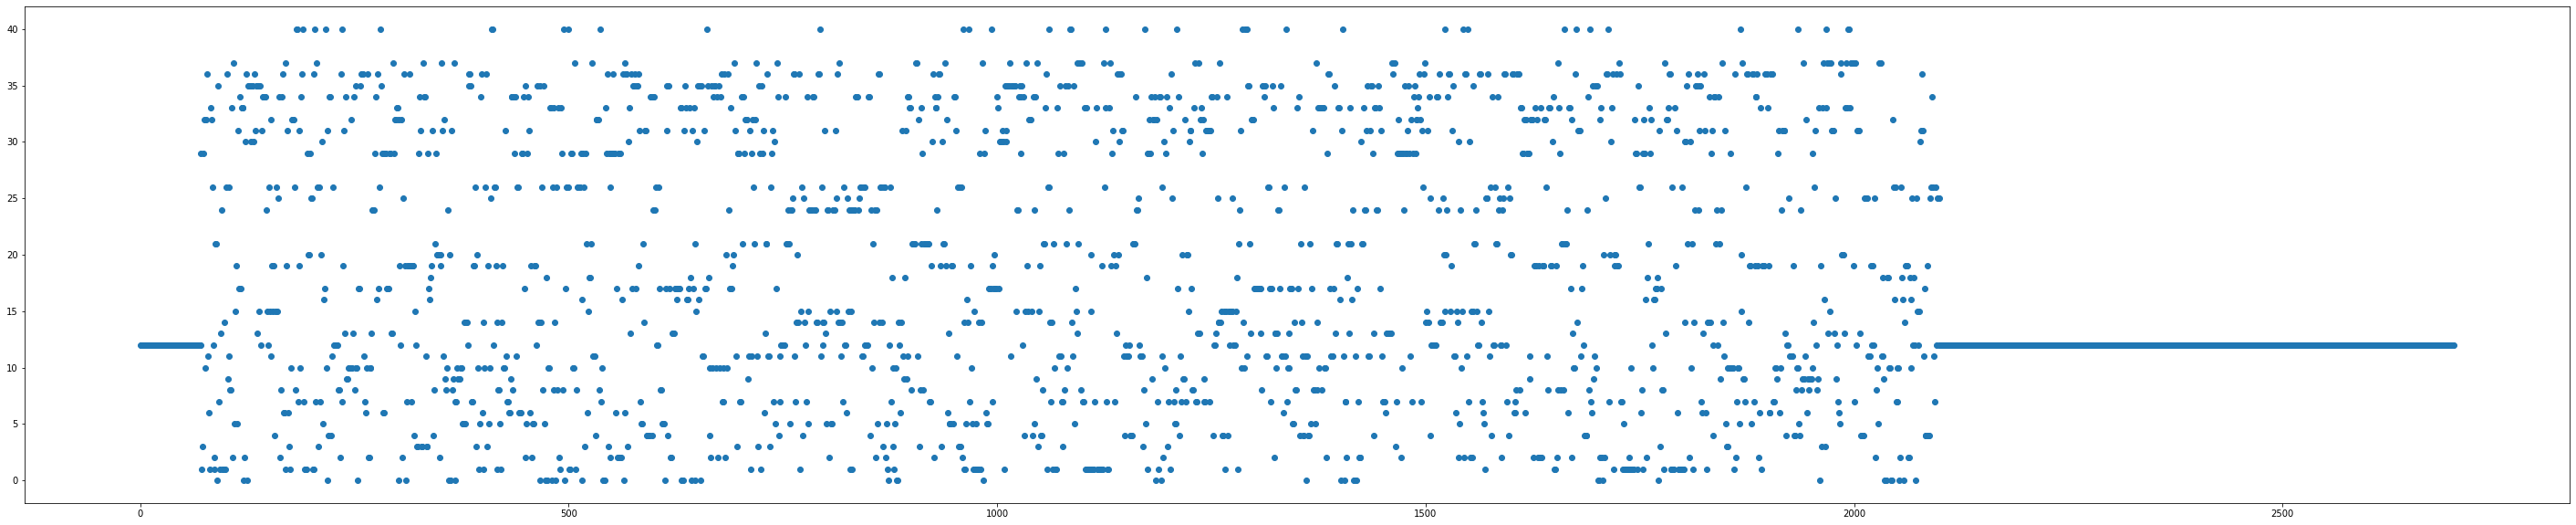

In [83]:
for y in groups[:num_to_plot]:
    x = np.arange(len(y))
    plt.scatter(x, y)
    plt.show()

In [ ]:
# plot histograms of atom and group frequencies
